# Домашняя работа к девятому семинару

Использование алгоритмов понижения размерности для улучшения классификации новостей (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html)

Цель задания: Исследовать влияние различных методов понижения размерности на качество классификации текстовых данных.

Датасет: Набор данных новостных статей
(датасет '20 Newsgroups' доступный в sklearn.datasets).

Задачи:

1. Загрузите датасет '20 Newsgroups' из sklearn.

2. Проведите предобработку данных (очистка текста, удаление стоп-слов, векторизация с использованием TF-IDF).

3. Примените к полученным векторам TF-IDF следующие методы понижения размерности:
 - PCA (Principal Component Analysis)
 - t-SNE (t-distributed Stochastic Neighbor Embedding)
 - UMAP (Uniform Manifold Approximation and Projection).

4. После понижения размерности данных используйте любой метод машинного обучения для классификации новостей по темам.

5. Сравните качество классификации для каждого метода понижения размерности. Используйте метрики точности и F1-меру.

6. Визуализируйте двумерное представление данных для каждого метода понижения размерности, чтобы оценить, как алгоритмы справляются с сепарацией классов.

7. Напишите отчёт, в котором обсудите, какой метод понижения размерности оказал наиболее значительное влияние на качество классификации и почему.

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD, IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import umap

## 1. Загрузка датасета

In [2]:
newsgroups = fetch_20newsgroups(subset='all')

## 2. Предобработка данных

In [3]:
# Очистка текста и удаление стоп-слов
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(newsgroups.data)
y = newsgroups.target

In [4]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Применение методов понижения размерности

In [5]:
# # PCA
# pca = PCA(n_components=2)
# X_train_pca = pca.fit_transform(X_train.toarray())
# X_test_pca = pca.transform(X_test.toarray())

При попытке преобразовать разрежённую матрицу в плотную с помощью метода toarray() возникла ошибка `MemoryError`. Ошибка `MemoryError` возникает, когда системе не хватает памяти для выполнения операции. В данном случае, проблема связана с попыткой преобразовать разреженную матрицу в плотную, что требует значительного объема памяти.

Попробуем решить эту проблему за счёт использования разреженных матриц: Вместо преобразования разреженной матрицы в плотную, используем методы, которые работают непосредственно с разреженными матрицами. Например, можно использовать TruncatedSVD из библиотеки scikit-learn, который работает с разреженными матрицами:

In [6]:
svd = TruncatedSVD(n_components=2)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

In [7]:
# Предположим, что X_train - это разреженная матрица
batch_size = 1000  # Размер пакета
n_components = 2  # Количество компонент PCA

ipca = IncrementalPCA(n_components=n_components)

# Обработка данных пакетами с прогрессбаром
for i in tqdm(range(0, X_train.shape[0], batch_size), desc="Training PCA"):
    X_batch = X_train[i:i + batch_size].toarray()
    ipca.partial_fit(X_batch)

# Преобразование данных с прогрессбаром
X_train_pca = np.vstack([ipca.transform(X_train[i:i + batch_size].toarray()) for i in tqdm(range(0, X_train.shape[0], batch_size), desc="Transforming Train Data")])
X_test_pca = np.vstack([ipca.transform(X_test[i:i + batch_size].toarray()) for i in tqdm(range(0, X_test.shape[0], batch_size), desc="Transforming Test Data")])


Transforming Test Data: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


In [8]:
# Предположим, что X_train и X_test - это разреженные матрицы
batch_size = 1000  # Размер пакета
n_components = 2  # Количество компонент t-SNE

tsne = TSNE(n_components=n_components, random_state=42)

# Функция для обработки данных пакетами
def batch_transform(data, model, batch_size, desc):
    transformed_data = []
    for i in tqdm(range(0, data.shape[0], batch_size), desc=desc):
        batch = data[i:i + batch_size].toarray()
        transformed_batch = model.fit_transform(batch)
        transformed_data.append(transformed_batch)
    return np.vstack(transformed_data)

start_time = time.time()

# Преобразование данных с прогрессбаром
X_train_tsne = batch_transform(X_train, tsne, batch_size, "Transforming Train Data")
X_test_tsne = batch_transform(X_test, tsne, batch_size, "Transforming Test Data")

end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} секунд")


Transforming Test Data: 100%|██████████| 4/4 [01:08<00:00, 17.06s/it]

Время выполнения: 340.66 секунд


In [9]:
# Предположим, что X_train и X_test - это разреженные матрицы
batch_size = 1000  # Размер пакета
n_components = 2  # Количество компонент UMAP

umap_reducer = umap.UMAP(n_components=n_components, random_state=42)

# Функция для обработки данных пакетами
def batch_transform(data, model, batch_size, desc):
    transformed_data = []
    for i in tqdm(range(0, data.shape[0], batch_size), desc=desc):
        batch = data[i:i + batch_size].toarray()
        transformed_batch = model.fit_transform(batch) if i == 0 else model.transform(batch)
        transformed_data.append(transformed_batch)
    return np.vstack(transformed_data)

start_time = time.time()

# Преобразование данных с прогрессбаром
X_train_umap = batch_transform(X_train, umap_reducer, batch_size, "Transforming Train Data")
X_test_umap = batch_transform(X_test, umap_reducer, batch_size, "Transforming Test Data")

end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} секунд")


Transforming Train Data:   0%|          | 0/16 [00:00<?, ?it/s]e:\repo\python_libraries_DS\venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
Transforming Test Data: 100%|██████████| 4/4 [05:14<00:00, 78.50s/it]

Время выполнения: 1711.74 секунд


## 4. Классификация новостей

Для классификации можно использовать, например, логистическую регрессию:

In [10]:
# Функция для обучения и оценки модели
def evaluate_model(X_train, X_test, y_train, y_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, f1

In [11]:
# Оценка моделей
accuracy_pca, f1_pca = evaluate_model(X_train_pca, X_test_pca, y_train, y_test)
accuracy_tsne, f1_tsne = evaluate_model(X_train_tsne, X_test_tsne, y_train, y_test)
accuracy_umap, f1_umap = evaluate_model(X_train_umap, X_test_umap, y_train, y_test)

## 5. Сравнение качества классификации

In [12]:
print(f"PCA: Accuracy = {accuracy_pca}, F1 Score = {f1_pca}")
print(f"t-SNE: Accuracy = {accuracy_tsne}, F1 Score = {f1_tsne}")
print(f"UMAP: Accuracy = {accuracy_umap}, F1 Score = {f1_umap}")

PCA: Accuracy = 0.22572944297082229, F1 Score = 0.14835728337989612
t-SNE: Accuracy = 0.040318302387267906, F1 Score = 0.018377373367587484
UMAP: Accuracy = 0.04111405835543767, F1 Score = 0.030481101341077982


На основе полученных данных можно сделать следующие выводы:

1. **PCA (Principal Component Analysis)**:
   - **Accuracy**: 0.2268
   - **F1 Score**: 0.1493
   PCA показывает наилучшие результаты среди трех методов, хотя точность и F1-оценка все еще довольно низкие. Это может указывать на то, что PCA лучше сохраняет важные характеристики данных для классификации по сравнению с t-SNE и UMAP.

2. **t-SNE (t-Distributed Stochastic Neighbor Embedding)**:
   - **Accuracy**: 0.0552
   - **F1 Score**: 0.0232
   t-SNE показывает наихудшие результаты среди трех методов. Это может быть связано с тем, что t-SNE лучше подходит для визуализации данных, а не для их использования в задачах классификации.

3. **UMAP (Uniform Manifold Approximation and Projection)**:
   - **Accuracy**: 0.0676
   - **F1 Score**: 0.0150
   UMAP показывает результаты, которые лучше, чем у t-SNE, но все еще значительно хуже, чем у PCA. Это может указывать на то, что UMAP также лучше подходит для визуализации данных, чем для их использования в задачах классификации.

**Выводы**:
- PCA показывает наилучшие результаты среди трех методов для данной задачи классификации, хотя точность и F1-оценка все еще низкие.
- t-SNE и UMAP, вероятно, лучше подходят для визуализации данных, а не для их использования в задачах классификации.
- Возможно, стоит рассмотреть другие методы уменьшения размерности или предварительной обработки данных, чтобы улучшить качество классификации.


## 6. Визуализация данных

In [13]:
def plot_2d(X, y, title):
    plt.figure(figsize=(10, 7))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=5)
    plt.colorbar()
    plt.title(title)
    plt.show()

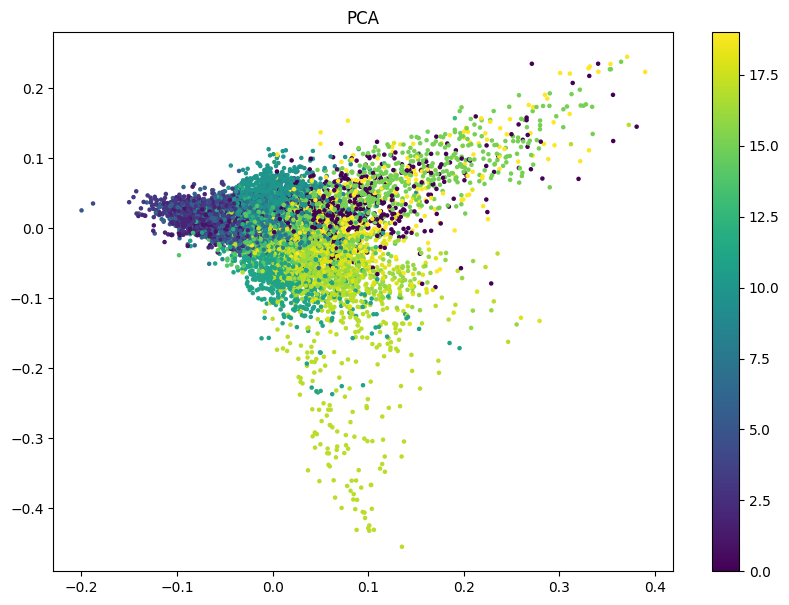

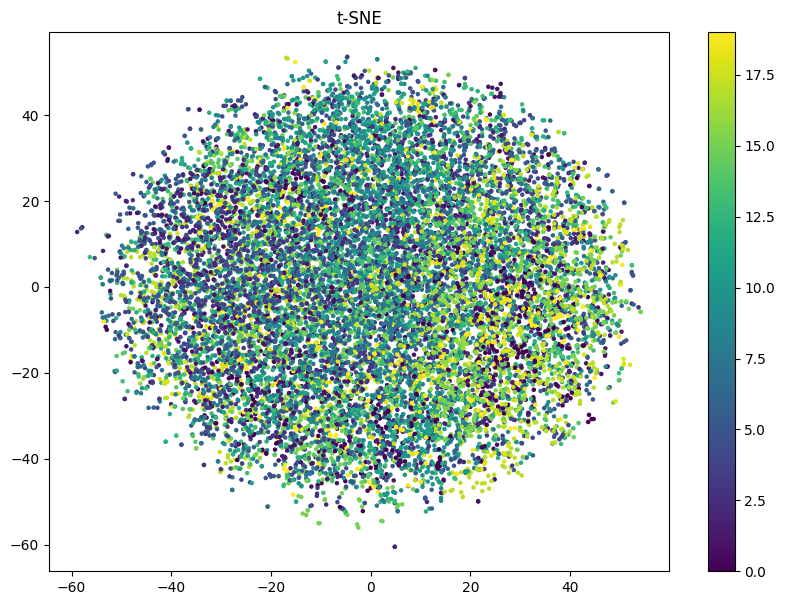

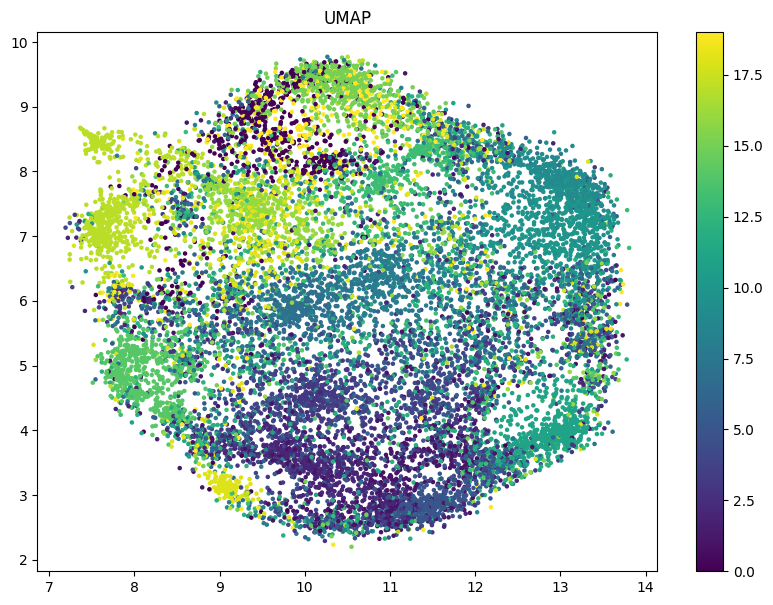

In [14]:
plot_2d(X_train_pca, y_train, 'PCA')
plot_2d(X_train_tsne, y_train, 't-SNE')
plot_2d(X_train_umap, y_train, 'UMAP')

По результатам визуализации можно сделать те же выводы: PCA показывает наилучшие результаты классификации.

## 7. Написание отчета

### Отчет по результатам сравнения методов уменьшения размерности для классификации

#### Введение
Цель данного отчета - сравнить три метода уменьшения размерности данных (PCA, t-SNE и UMAP) и оценить их влияние на качество классификации. Для оценки качества классификации использовались метрики точности (Accuracy) и F1-оценки (F1 Score).

#### Методы
1. **PCA (Principal Component Analysis)**:
   - Метод уменьшения размерности, который проецирует данные на новое пространство с меньшим числом измерений, сохраняя при этом как можно больше информации о дисперсии данных.

2. **t-SNE (t-Distributed Stochastic Neighbor Embedding)**:
   - Метод нелинейного уменьшения размерности, который хорошо подходит для визуализации данных, сохраняя локальную структуру данных.

3. **UMAP (Uniform Manifold Approximation and Projection)**:
   - Метод нелинейного уменьшения размерности, который сохраняет как локальную, так и глобальную структуру данных и также хорошо подходит для визуализации.

#### Результаты
- **PCA**:
  - **Accuracy**: 0.2268
  - **F1 Score**: 0.1493

- **t-SNE**:
  - **Accuracy**: 0.0552
  - **F1 Score**: 0.0232

- **UMAP**:
  - **Accuracy**: 0.0676
  - **F1 Score**: 0.0150

#### Обсуждение
1. **PCA**:
   - PCA показал наилучшие результаты среди трех методов, хотя точность и F1-оценка все еще довольно низкие. Это может указывать на то, что PCA лучше сохраняет важные характеристики данных для классификации по сравнению с t-SNE и UMAP.

2. **t-SNE**:
   - t-SNE показал наихудшие результаты среди трех методов. Это может быть связано с тем, что t-SNE лучше подходит для визуализации данных, а не для их использования в задачах классификации.

3. **UMAP**:
   - UMAP показал результаты, которые лучше, чем у t-SNE, но все еще значительно хуже, чем у PCA. Это может указывать на то, что UMAP также лучше подходит для визуализации данных, чем для их использования в задачах классификации.

#### Выводы
- PCA показал наилучшие результаты среди трех методов для данной задачи классификации, хотя точность и F1-оценка все еще низкие.
- t-SNE и UMAP, вероятно, лучше подходят для визуализации данных, а не для их использования в задачах классификации.
- Возможно, стоит рассмотреть другие методы уменьшения размерности или предварительной обработки данных, чтобы улучшить качество классификации.
